In [1]:
# ============================================================
# CNN Advanced Practice Notebook 04
# Transfer Learning with MobileNetV2 (CIFAR-10)
# ============================================================
# [KR]
# 목표:
# - 사전학습된 MobileNetV2(ImageNet)를 특징 추출기로 활용하여
#   CIFAR-10 이미지 분류 성능을 향상시킨다.
# - Freeze 학습과 Fine-tuning 학습의 차이를 비교한다.
#
# [JP]
# 目的:
# - ImageNetで事前学習されたMobileNetV2を特徴抽出器として利用し、
#   CIFAR-10画像分類性能を向上させる。
# - Freeze学習とFine-tuning学習の違いを比較する。
#
# 핵심 개념:
# - Transfer Learning: 대규모 데이터셋에서 학습된 특징을 재사용
# - Freeze: 사전학습 모델의 가중치를 고정
# - Fine-tuning: 상위 일부 레이어만 미세 조정
# ============================================================

In [4]:
# ------------------------------------------------------------
# 0) Library Import
# ------------------------------------------------------------
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [5]:
# ------------------------------------------------------------
# 1) Data Load (CIFAR-10)
# ------------------------------------------------------------
# CIFAR-10:
# - 32x32 RGB 이미지
# - 10개 클래스 분류 데이터셋
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [6]:
# ------------------------------------------------------------
# 2) Preprocess: Resize & MobileNetV2 전용 전처리
# ------------------------------------------------------------
# MobileNetV2는 더 큰 입력 해상도를 기대하므로
# CIFAR-10 이미지를 96x96으로 resize
x_train = tf.cast(x_train, tf.float32)
x_test  = tf.cast(x_test, tf.float32)

x_train = tf.image.resize(x_train, (96, 96), antialias=True)
x_test  = tf.image.resize(x_test, (96, 96), antialias=True)

# MobileNetV2 전용 전처리
# - 입력 분포를 사전학습 당시와 맞춤
x_train = preprocess_input(x_train)
x_test  = preprocess_input(x_test)

In [7]:
# ------------------------------------------------------------
# 3) Pre-trained MobileNetV2 (Feature Extractor)
# ------------------------------------------------------------
# - include_top=False: ImageNet 분류기 제거
# - CNN 부분만 특징 추출기로 사용
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(96, 96, 3)
)

# Freeze: 사전학습 가중치 고정
base_model.trainable = False

In [8]:
# ------------------------------------------------------------
# 4) Classifier Head 추가
# ------------------------------------------------------------
# CIFAR-10 분류를 위한 새로운 분류기 구성
x = base_model.output

# Feature map을 채널 단위로 요약
x = GlobalAveragePooling2D()(x)

# Fully Connected Layer
x = Dense(64, activation="relu")(x)

# Output Layer (10개 클래스)
outputs = Dense(10, activation="softmax")(x)

# 최종 모델 구성
model = Model(inputs=base_model.input, outputs=outputs)

In [9]:
# ------------------------------------------------------------
# 5) Training Step 1: Freeze Learning
# ------------------------------------------------------------
# - base_model은 고정
# - 새로 추가한 Dense 레이어만 학습
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

history_freeze = model.fit(
    x_train, y_train,
    epochs=5,
    validation_split=0.2,
    verbose=1
)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 96, 96, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 48, 48, 32)        │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 48, 48, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 48, 48, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 48, 48, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 48, 48, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 48, 48, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 48, 48, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 48, 48, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 48, 48, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 48, 48, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 48, 48, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 49, 49, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 24, 24, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,340,618 (8.93 MB)

 Trainable params: 82,634 (322.79 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
# ------------------------------------------------------------
# TL Head only summary (for Appendix)
# ------------------------------------------------------------
head_model = tf.keras.Model(
    inputs=base_model.output,   # backbone 출력
    outputs=outputs,            # softmax 출력
    name="TL_Head"
)

head_model.summary()


Model: "TL_Head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_153CLONE (InputLayer)   │ (None, 3, 3, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          81,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,634 (322.79 KB)

 Trainable params: 82,634 (322.79 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# ------------------------------------------------------------
# 6) Training Step 2: Fine-tuning
# ------------------------------------------------------------
# - base_model을 부분적으로 학습 가능 상태로 변경
# - 너무 하위 레이어는 고정하여 기존 특징 보존
base_model.trainable = True

# 상위 20개 레이어만 학습
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Fine-tuning 시에는 작은 학습률 사용
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_finetune = model.fit(
    x_train, y_train,
    epochs=5,
    validation_split=0.2,
    verbose=1
)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 172s 131ms/step - accuracy: 0.8262 - loss: 0.5620 - val_accuracy: 0.8639 - val_loss: 0.4563
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 163s 130ms/step - accuracy: 0.8717 - loss: 0.3778 - val_accuracy: 0.8628 - val_loss: 0.4378
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 160s 128ms/step - accuracy: 0.8936 - loss: 0.3062 - val_accuracy: 0.8665 - val_loss: 0.4303
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 161s 129ms/step - accuracy: 0.9088 - loss: 0.2614 - val_accuracy: 0.8704 - val_loss: 0.4110
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 156s 124ms/step - accuracy: 0.9226 - loss: 0.2224 - val_accuracy: 0.8735 - val_loss: 0.4046


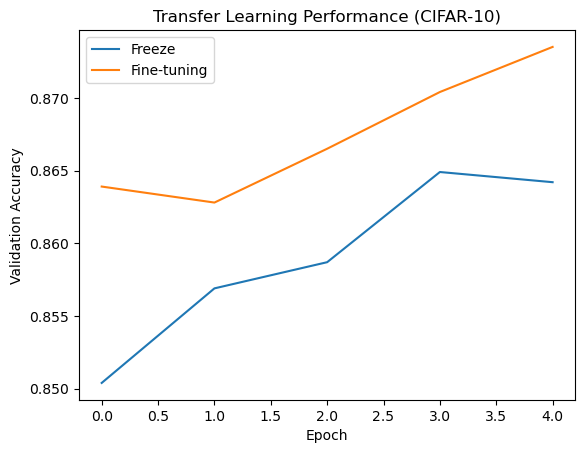

In [8]:
# ------------------------------------------------------------
# 7) Performance Comparison Visualization
# ------------------------------------------------------------
plt.plot(history_freeze.history["val_accuracy"], label="Freeze")
plt.plot(history_finetune.history["val_accuracy"], label="Fine-tuning")

plt.title("Transfer Learning Performance (CIFAR-10)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

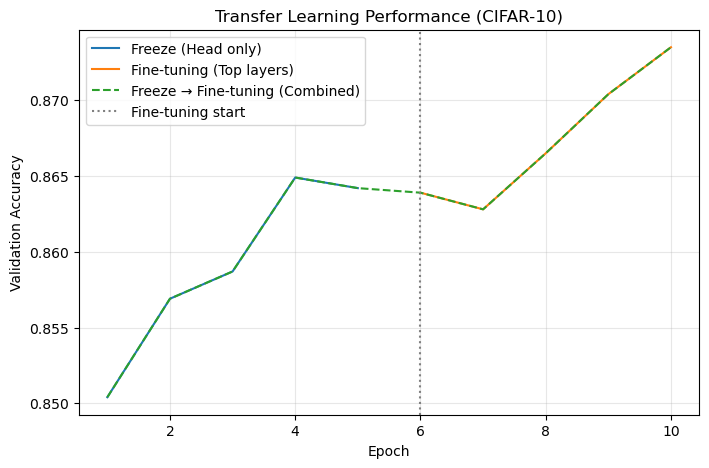

In [10]:
# ------------------------------------------------------------
# 8) Performance Comparison Visualization (Epoch starts from 1)
# ------------------------------------------------------------

# 개별 단계
val_acc_freeze = history_freeze.history["val_accuracy"]
val_acc_finetune = history_finetune.history["val_accuracy"]

# 길이
n_freeze = len(val_acc_freeze)
n_finetune = len(val_acc_finetune)

# epoch 번호 생성 (1부터)
epochs_freeze = range(1, n_freeze + 1)
epochs_finetune = range(n_freeze + 1, n_freeze + n_finetune + 1)
epochs_combined = range(1, n_freeze + n_finetune + 1)

# 이어붙인 전체 곡선
val_acc_combined = val_acc_freeze + val_acc_finetune

plt.figure(figsize=(8, 5))

# 단계별 곡선
plt.plot(epochs_freeze, val_acc_freeze, label="Freeze (Head only)")
plt.plot(epochs_finetune, val_acc_finetune, label="Fine-tuning (Top layers)")

# 전체 과정 곡선
plt.plot(epochs_combined, val_acc_combined, "--", label="Freeze → Fine-tuning (Combined)")

# Fine-tuning 시작 지점 (epoch 6)
plt.axvline(
    x=n_freeze + 1,
    color="gray",
    linestyle=":",
    label="Fine-tuning start"
)

plt.title("Transfer Learning Performance (CIFAR-10)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [20]:
# ------------------------------------------------------------
# 1) notebook1 
# ------------------------------------------------------------
# ------------------------------------------------------------
# Baseline CNN Model Definition (same as Notebook1)
# ------------------------------------------------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def build_model(input_shape=(32, 32, 3), num_classes=10):

    model = Sequential([
        # 첫 번째 합성곱 층
        Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        MaxPooling2D(),

        # 두 번째 합성곱 층
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(),

        # Flatten
        Flatten(),

        # Fully Connected
        Dense(64, activation="relu"),

        # Output
        Dense(num_classes, activation="softmax"),
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

import tensorflow as tf

# raw 다시 로드
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = tf.keras.datasets.cifar10.load_data()

EPOCHS = 10
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
VAL_SIZE = int(0.2 * len(x_train_raw))  # 10000

# 간단히 앞 10000개를 val로 (완전 stratify는 아니지만 메모리 안전)
x_val_raw, y_val_raw = x_train_raw[:VAL_SIZE], y_train_raw[:VAL_SIZE]
x_tr_raw, y_tr_raw   = x_train_raw[VAL_SIZE:], y_train_raw[VAL_SIZE:]

def preprocess_base(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

train_ds = (tf.data.Dataset.from_tensor_slices((x_tr_raw, y_tr_raw))
            .shuffle(40000)
            .map(preprocess_base, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((x_val_raw, y_val_raw))
          .map(preprocess_base, num_parallel_calls=AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(AUTOTUNE))

model_base = build_model()
history_base = model_base.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=1)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.4332 - loss: 1.5634 - val_accuracy: 0.5370 - val_loss: 1.3100
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5687 - loss: 1.2171 - val_accuracy: 0.5940 - val_loss: 1.1363
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6179 - loss: 1.0917 - val_accuracy: 0.6120 - val_loss: 1.0959
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6459 - loss: 1.0096 - val_accuracy: 0.6458 - val_loss: 1.0071
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6728 - loss: 0.9412 - val_accuracy: 0.6623 - val_loss: 0.9678
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6908 - loss: 0.8891 - val_accuracy: 0.6740 - val_loss: 0.9444
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7114 - loss: 0.8384 - val_accuracy: 0.6792 - val_loss: 0.9394
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7211 - loss: 0.8046 - val

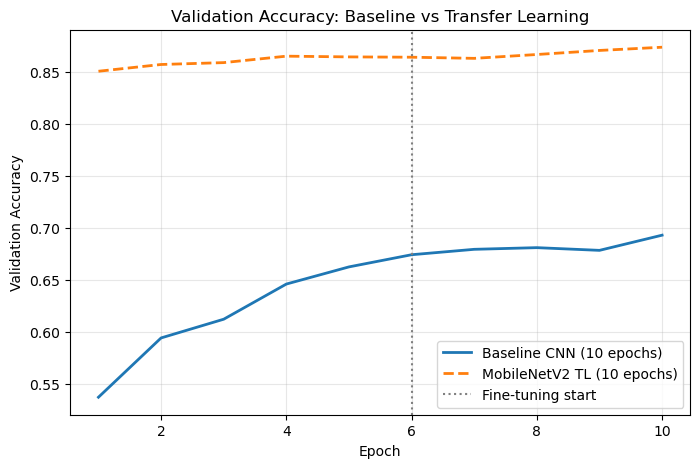

In [21]:
# ------------------------------------------------------------
# Compare: Baseline(10ep) vs Transfer(Freeze 5 + Fine-tune 5 = 10ep)
# ------------------------------------------------------------
import matplotlib.pyplot as plt

# Baseline (10 epochs)
val_acc_base = history_base.history["val_accuracy"]
epochs_base = range(1, len(val_acc_base) + 1)

# Transfer (10 epochs combined)
val_acc_freeze = history_freeze.history["val_accuracy"]
val_acc_finetune = history_finetune.history["val_accuracy"]
val_acc_tl = val_acc_freeze + val_acc_finetune
epochs_tl = range(1, len(val_acc_tl) + 1)

plt.figure(figsize=(8, 5))

plt.plot(epochs_base, val_acc_base, label="Baseline CNN (10 epochs)", linewidth=2)
plt.plot(epochs_tl, val_acc_tl, "--", label="MobileNetV2 TL (10 epochs)", linewidth=2)

# Fine-tuning start point (epoch 6)
plt.axvline(x=len(val_acc_freeze) + 1, color="gray", linestyle=":", label="Fine-tuning start")

plt.title("Validation Accuracy: Baseline vs Transfer Learning")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# ------------------------------------------------------------
# 8) Analysis Questions (과제용)
# ------------------------------------------------------------
# 1) Freeze와 Fine-tuning 성능 차이를 표로 정리하시오.
#    - Freeze: 사전학습 특징 고정 → 안정적이지만 성능 한계
#    - Fine-tuning: 상위 특징 재조정 → 더 높은 성능 가능
#
# 2) 학습률을 변경하면 어떤 현상이 발생하는가?
#    - 학습률이 크면: 기존 사전학습 가중치가 급격히 변해 성능 저하
#    - 학습률이 작으면: 안정적이지만 수렴 속도 느림
#
# 3) 데이터가 더 적을수록 어떤 전략이 유리한가?
#    - 데이터가 적을수록 Freeze 전략이 유리
#    - Fine-tuning은 과적합 위험 증가